# <h1><center> Homework 7 </center></h1>

In [1]:
import warnings
warnings.simplefilter('ignore')

from functools import partial

import pandas as pd
import numpy as np
import pandas_profiling as pp

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import rankdata
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
import xgbfir
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif


%matplotlib inline
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
plt.rcParams['figure.figsize'] = 16, 10

In [2]:
train = pd.read_csv('../data/train_5.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/test_5.csv', sep='\t', index_col=0)

## <h1><center>Preprocess</center></h1>

In [3]:
# 9 == 2 in both test and train, 140 and 164 have constant value 0 in both train and test
redundant_columns = ['9', '140', '164'] 
# 11 has constant value 1 in test
use_only_ones = ['11']
# those features have constant value 0 in test
use_only_zeros = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
# those features have constant value 0 inly in train
zero_train_features = ['152', '160']
#too much zeros
too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [4]:
#152 and 160 is useless
for feature in zero_train_features:
    print(f"Len of test where {feature} != 0 is {len(test[test[feature]==1])}")
    redundant_columns.append(feature)

Len of test where 152 != 0 is 1
Len of test where 160 != 0 is 1


In [5]:
def preprocess(train_df, test_df):
    _train = train_df.drop(redundant_columns, axis=1)
    _test = test_df.drop(redundant_columns, axis=1)
    for column in use_only_zeros:
        _train = _train[_train[column] == 0].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    for column in use_only_ones:
        _train = _train[_train[column] == 1].drop(column, axis=1)
        _test.drop(column, axis=1, inplace=True)
    X_train = _train.drop('0', axis=1).reset_index(drop=True)
    y_train = _train['0'].reset_index(drop=True)
    X_test = _test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

In [6]:
X_train, y_train, X_test = preprocess(train, test)

In [7]:
skf = StratifiedKFold(n_splits=10, random_state=42)

## <h1><center> All in one methods </center></h1>

In [8]:
def calculate(model, parameters, X_train, y_train, cv_iterator):
    
    gs = GridSearchCV(
    estimator=model,
    param_grid=parameters, 
    cv=cv_iterator, 
    error_score=1,  
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=1)

    gs.fit(X=X_train, y=y_train)

    best_score = gs.best_score_
    best_model = gs.best_estimator_
    
    return best_model, best_score


def get_submission(model, X_train, X_test, y_train, filename):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    make_file(y_pred, filename)
    return y_pred


def make_file(y_pred, filename):
    submission = pd.Series (y_pred, name='_VAL_' )
    submission.to_csv(filename, index_label='_ID_', header =True )
    
    
def get_pred_cv(estimator, X_train, y_train=y_train, cv=skf):
    k=0
    pred_cv = []
    for train, val in cv.split(X_train, y_train):
        k+=1
        print(f"Iteration: {k}")
        estimator.fit(X_train.iloc[train], y_train[train])
        pred_cv.append([y_train[val], estimator.predict_proba(X_train.iloc[val])[:,1]])
    return pred_cv


def get_stacked(X_train, X_test, predictions, pred_cv, prefix, cv=skf, y_train=y_train):
    X_train_stacked = X_train.copy()
    X_test_stacked = X_test.copy()
    X_train_stacked[prefix + "_preds"] = 0
    X_test_stacked[prefix + "_preds"] = predictions
    for i, fold in enumerate(cv.split(X_train, y_train)):
        train_stacked, val = fold[0], fold[1]
        X_train_stacked.iloc[val, -1] = pred_cv[i][1]
    return X_train_stacked, X_test_stacked


def check_train_score(params, lgb_data, data, target, kf, num_rounds):
    roc_auc = []
    for train, val in kf.split(data,target):
        temp_lgb_train = lgb_data.subset(train, params={"free_raw_data":False})
        temp_lgb_val = lgb_data.subset(val, params={"free_raw_data" :False})
        temp_model = lgb.train(params, temp_lgb_train, num_rounds, verbose_eval=num_rounds)
        roc_auc.append([roc_auc_score(target[train],temp_model.predict(data.loc[train])),
                        roc_auc_score(target[val],temp_model.predict(data.loc[val]))])
    return np.mean(roc_auc, axis=0)

def check_train_score_nd_array(params, lgb_data, data, target, kf, num_rounds):
    roc_auc = []
    for train, val in kf.split(data,target):
        temp_lgb_train = lgb_data.subset(train)
        temp_lgb_val = lgb_data.subset(val)
        temp_model = lgb.train(params, temp_lgb_train, num_rounds, verbose_eval=num_rounds)
        roc_auc.append([roc_auc_score(target[train],temp_model.predict(data[train])), roc_auc_score(target[val],temp_model.predict(data[val]))])
    return np.mean(roc_auc, axis=0)


def train_score(model, X_train, y_train, cv):
    roc_auc = []
    for train, val in cv.split(X_train, y_train):
            temp_train = X_train.loc(train)
            temp_val = X_train.loc(val)
            model.fit(temp_train, y_train[train])
            roc_auc.append(roc_auc_score(y_train[train], model.predict_proba(temp_train)[:,1]))
    return np.mean(roc_auc)

# <center> XGBoost

In [21]:
xgb_train = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
xgb_test = xgb.DMatrix(X_test, feature_names=X_train.columns)

In [22]:
#0.76480375

params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 42,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'  
}

In [23]:
results_xgb = xgb.cv(params_xgb, xgb_train, num_boost_round=10000, folds=skf, early_stopping_rounds=10, verbose_eval=1)

[0]	train-auc:0.710628+0.00313931	test-auc:0.678066+0.00462668
[1]	train-auc:0.73157+0.00597765	test-auc:0.69311+0.00339878
[2]	train-auc:0.742757+0.00452808	test-auc:0.70256+0.00425403
[3]	train-auc:0.747692+0.00360729	test-auc:0.706937+0.00449244
[4]	train-auc:0.749963+0.00332396	test-auc:0.710194+0.00389159
[5]	train-auc:0.753121+0.00585303	test-auc:0.710681+0.00275986
[6]	train-auc:0.754689+0.00464145	test-auc:0.71111+0.00288613
[7]	train-auc:0.75733+0.0051852	test-auc:0.712402+0.00245126
[8]	train-auc:0.75816+0.00420537	test-auc:0.71276+0.00255103
[9]	train-auc:0.759471+0.00358881	test-auc:0.713049+0.00334862
[10]	train-auc:0.759957+0.00424106	test-auc:0.713215+0.00329054
[11]	train-auc:0.761546+0.00442647	test-auc:0.7135+0.00274876
[12]	train-auc:0.761956+0.00391905	test-auc:0.71436+0.00363126
[13]	train-auc:0.762814+0.00429183	test-auc:0.714991+0.00323505
[14]	train-auc:0.763618+0.00484824	test-auc:0.715458+0.00317238
[15]	train-auc:0.764494+0.00505509	test-auc:0.71574+0.0028657

[129]	train-auc:0.810303+0.00287486	test-auc:0.726176+0.00432487
[130]	train-auc:0.810803+0.00286475	test-auc:0.726432+0.00435958
[131]	train-auc:0.811164+0.00303496	test-auc:0.726578+0.00423899
[132]	train-auc:0.811433+0.00309089	test-auc:0.726709+0.00424856
[133]	train-auc:0.811781+0.00326583	test-auc:0.726854+0.00426774
[134]	train-auc:0.812291+0.00317072	test-auc:0.726916+0.00418155
[135]	train-auc:0.812676+0.00303367	test-auc:0.726949+0.00423284
[136]	train-auc:0.812985+0.00302825	test-auc:0.727006+0.00428229
[137]	train-auc:0.813326+0.00309677	test-auc:0.727119+0.00424929
[138]	train-auc:0.813722+0.00294929	test-auc:0.727156+0.0043159
[139]	train-auc:0.814241+0.00273145	test-auc:0.727252+0.00429675
[140]	train-auc:0.814632+0.00265572	test-auc:0.727386+0.00426821
[141]	train-auc:0.815019+0.00260883	test-auc:0.727388+0.00425213
[142]	train-auc:0.815452+0.00273742	test-auc:0.727496+0.00432137
[143]	train-auc:0.815876+0.00285793	test-auc:0.727604+0.00426221
[144]	train-auc:0.81614+0.

[256]	train-auc:0.856648+0.00155498	test-auc:0.735696+0.00506157
[257]	train-auc:0.856897+0.00157921	test-auc:0.735752+0.00505016
[258]	train-auc:0.857205+0.0015699	test-auc:0.735817+0.00503957
[259]	train-auc:0.857473+0.00156293	test-auc:0.735827+0.00501053
[260]	train-auc:0.857801+0.00153011	test-auc:0.735875+0.00503257
[261]	train-auc:0.858068+0.00153007	test-auc:0.735896+0.00503837
[262]	train-auc:0.858349+0.00149877	test-auc:0.736021+0.00503188
[263]	train-auc:0.858651+0.00153907	test-auc:0.736097+0.00501675
[264]	train-auc:0.858988+0.00153025	test-auc:0.736138+0.0050269
[265]	train-auc:0.859379+0.0015472	test-auc:0.736191+0.00502729
[266]	train-auc:0.85965+0.00155087	test-auc:0.736258+0.00499748
[267]	train-auc:0.859901+0.001498	test-auc:0.736316+0.00500787
[268]	train-auc:0.860235+0.00157744	test-auc:0.736394+0.0049971
[269]	train-auc:0.860457+0.00159762	test-auc:0.736458+0.00501988
[270]	train-auc:0.860723+0.00158531	test-auc:0.736486+0.00501824
[271]	train-auc:0.861066+0.00152

[383]	train-auc:0.890485+0.00130742	test-auc:0.739506+0.00540897
[384]	train-auc:0.890709+0.0012655	test-auc:0.739528+0.00544782
[385]	train-auc:0.89094+0.00128825	test-auc:0.739515+0.00540726
[386]	train-auc:0.891224+0.00129583	test-auc:0.739564+0.00544535
[387]	train-auc:0.891444+0.00133602	test-auc:0.739612+0.0054375
[388]	train-auc:0.891684+0.00134434	test-auc:0.739586+0.00545347
[389]	train-auc:0.891884+0.00133909	test-auc:0.7396+0.00550453
[390]	train-auc:0.892163+0.00132087	test-auc:0.73959+0.00555078
[391]	train-auc:0.89237+0.00131195	test-auc:0.73963+0.0055133
[392]	train-auc:0.892546+0.00126009	test-auc:0.739642+0.0055279
[393]	train-auc:0.892786+0.00131663	test-auc:0.739637+0.00553777
[394]	train-auc:0.892984+0.00131599	test-auc:0.739613+0.00555615
[395]	train-auc:0.893186+0.00132348	test-auc:0.739637+0.0055982
[396]	train-auc:0.893374+0.00135713	test-auc:0.739644+0.0055735
[397]	train-auc:0.893598+0.00137726	test-auc:0.739686+0.00555122
[398]	train-auc:0.893765+0.00139603	t

[511]	train-auc:0.913924+0.00166233	test-auc:0.741399+0.00614911
[512]	train-auc:0.914083+0.00167353	test-auc:0.741404+0.00615
[513]	train-auc:0.91421+0.00173429	test-auc:0.741414+0.00612528
[514]	train-auc:0.914363+0.00170871	test-auc:0.741445+0.00616097
[515]	train-auc:0.914526+0.00171169	test-auc:0.741438+0.00614872
[516]	train-auc:0.914614+0.00173826	test-auc:0.741435+0.00616106
[517]	train-auc:0.914776+0.00174188	test-auc:0.74144+0.00619276
[518]	train-auc:0.914947+0.0017468	test-auc:0.741457+0.00621347
[519]	train-auc:0.915076+0.00177765	test-auc:0.741475+0.00623078
[520]	train-auc:0.915211+0.00174144	test-auc:0.741504+0.00626078
[521]	train-auc:0.915387+0.00171522	test-auc:0.741514+0.00628143
[522]	train-auc:0.91559+0.00167722	test-auc:0.741508+0.0062543
[523]	train-auc:0.915713+0.00166196	test-auc:0.741517+0.00627178
[524]	train-auc:0.915922+0.00159234	test-auc:0.741568+0.00629063
[525]	train-auc:0.916103+0.00163409	test-auc:0.741542+0.00625433
[526]	train-auc:0.916206+0.001621

In [24]:
results_xgb.iloc[-1,:]

test-auc-mean     0.742314
test-auc-std      0.006469
train-auc-mean    0.927903
train-auc-std     0.001805
Name: 607, dtype: float64

In [25]:
xgb_model = xgb.train(params_xgb, xgb_train, len(results_xgb))

In [26]:
xgb_predictions = xgb_model.predict(xgb_test)
make_file(xgb_predictions, "hw7_submissions/xgb_predictions.csv")

In [27]:
xgb_pred_cv = []
k=0
for train, val in skf.split(X_train, y_train):
    k+=1
    print(f"Iteration: {k}")
    xgb_train_temp = xgb.DMatrix(X_train.iloc[train], y_train[train])
    temp_xgb_model = xgb.train(params_xgb,xgb_train_temp , len(results_xgb))
    xgb_pred_cv.append([y_train[val], temp_xgb_model.predict(xgb.DMatrix(X_train.iloc[val]))])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


# <center> Light GBM

In [174]:
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False) 

In [175]:
params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.03,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    'max_leaves': 70,
    'max_depth': 8}

In [176]:
results_lgb = lgb.cv(params_lgb, lgb_train, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=20, verbose_eval=1)

[1]	cv_agg's auc: 0.682759 + 0.00881986
[2]	cv_agg's auc: 0.699119 + 0.0103793
[3]	cv_agg's auc: 0.703574 + 0.0105283
[4]	cv_agg's auc: 0.707033 + 0.00942687
[5]	cv_agg's auc: 0.709456 + 0.00866551
[6]	cv_agg's auc: 0.710255 + 0.00884168
[7]	cv_agg's auc: 0.709995 + 0.00840763
[8]	cv_agg's auc: 0.710017 + 0.00865017
[9]	cv_agg's auc: 0.710586 + 0.00862808
[10]	cv_agg's auc: 0.71125 + 0.00927665
[11]	cv_agg's auc: 0.711612 + 0.0091405
[12]	cv_agg's auc: 0.711968 + 0.00882833
[13]	cv_agg's auc: 0.712179 + 0.00878054
[14]	cv_agg's auc: 0.71269 + 0.00910849
[15]	cv_agg's auc: 0.713642 + 0.00920807
[16]	cv_agg's auc: 0.714322 + 0.0091917
[17]	cv_agg's auc: 0.715469 + 0.00960568
[18]	cv_agg's auc: 0.716438 + 0.00930788
[19]	cv_agg's auc: 0.716562 + 0.00967869
[20]	cv_agg's auc: 0.7174 + 0.00969129
[21]	cv_agg's auc: 0.718154 + 0.00944434
[22]	cv_agg's auc: 0.718163 + 0.00955479
[23]	cv_agg's auc: 0.718627 + 0.00955146
[24]	cv_agg's auc: 0.719152 + 0.00918794
[25]	cv_agg's auc: 0.719491 + 0.0

[202]	cv_agg's auc: 0.745865 + 0.0108355
[203]	cv_agg's auc: 0.745905 + 0.0108498
[204]	cv_agg's auc: 0.745927 + 0.0108405
[205]	cv_agg's auc: 0.745924 + 0.0107953
[206]	cv_agg's auc: 0.745967 + 0.0107603
[207]	cv_agg's auc: 0.745942 + 0.0107991
[208]	cv_agg's auc: 0.745988 + 0.0109243
[209]	cv_agg's auc: 0.745993 + 0.0109093
[210]	cv_agg's auc: 0.745992 + 0.0109878
[211]	cv_agg's auc: 0.74599 + 0.0110312
[212]	cv_agg's auc: 0.746044 + 0.0111133
[213]	cv_agg's auc: 0.746119 + 0.0110653
[214]	cv_agg's auc: 0.74616 + 0.0110975
[215]	cv_agg's auc: 0.746099 + 0.0111178
[216]	cv_agg's auc: 0.746159 + 0.0111121
[217]	cv_agg's auc: 0.746219 + 0.0111663
[218]	cv_agg's auc: 0.746256 + 0.0112226
[219]	cv_agg's auc: 0.746327 + 0.0111827
[220]	cv_agg's auc: 0.746298 + 0.0112022
[221]	cv_agg's auc: 0.746335 + 0.0112361
[222]	cv_agg's auc: 0.746325 + 0.011285
[223]	cv_agg's auc: 0.746352 + 0.0112026
[224]	cv_agg's auc: 0.746378 + 0.0111478
[225]	cv_agg's auc: 0.746413 + 0.0111187
[226]	cv_agg's auc:

In [178]:
res_lgb = check_train_score(params_lgb, lgb_train, X_train, y_train, skf, len(results_lgb['auc-mean']))
print(f"Train score: {res_lgb[0]}, CV score: {res_lgb[1]}")

Train score: 0.8699769552138514, CV score: 0.7474484680988607


# <center> Let's go feature

## <center> Dimensionality Reduction

### PCA

In [26]:
pca = PCA(n_components=240)
X_train_pca = pca.fit_transform(X_train, y_train)

In [27]:
lgb_train_pca = lgb.Dataset(X_train_pca, label=y_train, free_raw_data=False)

In [28]:
results_lgb_pca = lgb.cv(params_lgb, lgb_train_pca, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.631095 + 0.0144802
[2]	cv_agg's auc: 0.668861 + 0.0114096
[3]	cv_agg's auc: 0.684917 + 0.0094004
[4]	cv_agg's auc: 0.69073 + 0.008526
[5]	cv_agg's auc: 0.694437 + 0.00866622
[6]	cv_agg's auc: 0.69798 + 0.00816865
[7]	cv_agg's auc: 0.700103 + 0.00800613
[8]	cv_agg's auc: 0.701298 + 0.0081546
[9]	cv_agg's auc: 0.702118 + 0.00927995
[10]	cv_agg's auc: 0.703376 + 0.009555
[11]	cv_agg's auc: 0.704624 + 0.009146
[12]	cv_agg's auc: 0.705042 + 0.00920488
[13]	cv_agg's auc: 0.705097 + 0.00858253
[14]	cv_agg's auc: 0.70492 + 0.00859677
[15]	cv_agg's auc: 0.70527 + 0.00848774
[16]	cv_agg's auc: 0.705785 + 0.00848187
[17]	cv_agg's auc: 0.706386 + 0.00824306
[18]	cv_agg's auc: 0.706785 + 0.00826298
[19]	cv_agg's auc: 0.707022 + 0.0082291
[20]	cv_agg's auc: 0.70734 + 0.00822275
[21]	cv_agg's auc: 0.707533 + 0.00822222
[22]	cv_agg's auc: 0.708421 + 0.0081533
[23]	cv_agg's auc: 0.709194 + 0.00786623
[24]	cv_agg's auc: 0.709635 + 0.00796137
[25]	cv_agg's auc: 0.709872 + 0.00773628
[

[200]	cv_agg's auc: 0.734012 + 0.00853852
[201]	cv_agg's auc: 0.734138 + 0.0086017
[202]	cv_agg's auc: 0.734119 + 0.00865225
[203]	cv_agg's auc: 0.734101 + 0.00851859
[204]	cv_agg's auc: 0.734152 + 0.00858446
[205]	cv_agg's auc: 0.734146 + 0.00857269
[206]	cv_agg's auc: 0.734175 + 0.00855985
[207]	cv_agg's auc: 0.734227 + 0.00858347
[208]	cv_agg's auc: 0.734219 + 0.00852055
[209]	cv_agg's auc: 0.734269 + 0.00856199
[210]	cv_agg's auc: 0.73421 + 0.00859456
[211]	cv_agg's auc: 0.734251 + 0.00856067
[212]	cv_agg's auc: 0.73425 + 0.00847512
[213]	cv_agg's auc: 0.734293 + 0.00856935
[214]	cv_agg's auc: 0.734335 + 0.00848778
[215]	cv_agg's auc: 0.734389 + 0.00856992
[216]	cv_agg's auc: 0.734389 + 0.00858078
[217]	cv_agg's auc: 0.734399 + 0.00857629
[218]	cv_agg's auc: 0.734419 + 0.00862063
[219]	cv_agg's auc: 0.734426 + 0.00856191
[220]	cv_agg's auc: 0.734371 + 0.00860772
[221]	cv_agg's auc: 0.73438 + 0.00844344
[222]	cv_agg's auc: 0.734334 + 0.00850435
[223]	cv_agg's auc: 0.734342 + 0.00850

In [29]:
res_lgb_pca = check_train_score_nd_array(params_lgb, lgb_train_pca, X_train_pca, y_train, skf, len(results_lgb_pca['auc-mean']))
print(f"Train score: {res_lgb_pca[0]}, CV score: {res_lgb_pca[1]}")

Train score: 0.8940249449474406, CV score: 0.7346037568099579


### ICA

In [38]:
ica = FastICA(n_components=150)
X_train_ica = ica.fit_transform(X_train, y_train)

In [39]:
lgb_train_ica = lgb.Dataset(X_train_ica, label=y_train, free_raw_data=False)

In [42]:
results_lgb_ica = lgb.cv(params_lgb, lgb_train_ica, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=30, verbose_eval=1)

[1]	cv_agg's auc: 0.657673 + 0.0174482
[2]	cv_agg's auc: 0.672264 + 0.0154536
[3]	cv_agg's auc: 0.684046 + 0.0135343
[4]	cv_agg's auc: 0.695171 + 0.0138926
[5]	cv_agg's auc: 0.697668 + 0.0142955
[6]	cv_agg's auc: 0.700193 + 0.0147289
[7]	cv_agg's auc: 0.700833 + 0.0147591
[8]	cv_agg's auc: 0.701304 + 0.0141566
[9]	cv_agg's auc: 0.702383 + 0.013423
[10]	cv_agg's auc: 0.703392 + 0.0141124
[11]	cv_agg's auc: 0.704791 + 0.0131051
[12]	cv_agg's auc: 0.705102 + 0.0127781
[13]	cv_agg's auc: 0.705085 + 0.013132
[14]	cv_agg's auc: 0.706475 + 0.0128356
[15]	cv_agg's auc: 0.707153 + 0.0121104
[16]	cv_agg's auc: 0.707731 + 0.0117848
[17]	cv_agg's auc: 0.708007 + 0.0115893
[18]	cv_agg's auc: 0.707805 + 0.0114867
[19]	cv_agg's auc: 0.708171 + 0.0118193
[20]	cv_agg's auc: 0.708333 + 0.0119255
[21]	cv_agg's auc: 0.708811 + 0.0118994
[22]	cv_agg's auc: 0.709156 + 0.0116731
[23]	cv_agg's auc: 0.709736 + 0.0115833
[24]	cv_agg's auc: 0.710115 + 0.011811
[25]	cv_agg's auc: 0.710761 + 0.0116694
[26]	cv_agg'

[203]	cv_agg's auc: 0.738412 + 0.00976183
[204]	cv_agg's auc: 0.738452 + 0.00966675
[205]	cv_agg's auc: 0.738578 + 0.00975853
[206]	cv_agg's auc: 0.738604 + 0.00977062
[207]	cv_agg's auc: 0.738568 + 0.00977015
[208]	cv_agg's auc: 0.738592 + 0.00974892
[209]	cv_agg's auc: 0.738542 + 0.00978911
[210]	cv_agg's auc: 0.738477 + 0.00978194
[211]	cv_agg's auc: 0.738516 + 0.00982144
[212]	cv_agg's auc: 0.738748 + 0.00971715
[213]	cv_agg's auc: 0.738761 + 0.00977925
[214]	cv_agg's auc: 0.738815 + 0.00970657
[215]	cv_agg's auc: 0.738856 + 0.00972864
[216]	cv_agg's auc: 0.738949 + 0.00973235
[217]	cv_agg's auc: 0.738878 + 0.00968298
[218]	cv_agg's auc: 0.738844 + 0.00970314
[219]	cv_agg's auc: 0.738852 + 0.0097684
[220]	cv_agg's auc: 0.738855 + 0.00974017
[221]	cv_agg's auc: 0.73884 + 0.00984954
[222]	cv_agg's auc: 0.738872 + 0.00984722
[223]	cv_agg's auc: 0.738834 + 0.00996704
[224]	cv_agg's auc: 0.738906 + 0.0100172
[225]	cv_agg's auc: 0.738951 + 0.0101015
[226]	cv_agg's auc: 0.738979 + 0.01017

In [43]:
res_lgb_ica = check_train_score_nd_array(params_lgb, lgb_train_ica, X_train_ica, y_train, skf, len(results_lgb_ica['auc-mean']))
print(f"Train score: {res_lgb_ica[0]}, CV score: {res_lgb_ica[1]}")

Train score: 0.887715654994427, CV score: 0.739120621250832


### t-SNE

In [426]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train, y_train)

In [427]:
lgb_train_tsne = lgb.Dataset(X_train_tsne, label=y_train, free_raw_data=False)

In [428]:
results_lgb_tsne = lgb.cv(params_lgb, lgb_train_tsne, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.611758 + 0.00876016
[2]	cv_agg's auc: 0.651342 + 0.00776493
[3]	cv_agg's auc: 0.648101 + 0.00668506
[4]	cv_agg's auc: 0.653785 + 0.00732834
[5]	cv_agg's auc: 0.652423 + 0.00684875
[6]	cv_agg's auc: 0.654486 + 0.0078612
[7]	cv_agg's auc: 0.654455 + 0.00741789
[8]	cv_agg's auc: 0.655274 + 0.00799543
[9]	cv_agg's auc: 0.655286 + 0.00756244
[10]	cv_agg's auc: 0.655964 + 0.00788947
[11]	cv_agg's auc: 0.656024 + 0.00754611
[12]	cv_agg's auc: 0.656397 + 0.00779201
[13]	cv_agg's auc: 0.656718 + 0.00769273
[14]	cv_agg's auc: 0.65694 + 0.00810696
[15]	cv_agg's auc: 0.656901 + 0.00783795
[16]	cv_agg's auc: 0.656951 + 0.00804398
[17]	cv_agg's auc: 0.657141 + 0.00771966
[18]	cv_agg's auc: 0.657294 + 0.00801642
[19]	cv_agg's auc: 0.657379 + 0.00795326
[20]	cv_agg's auc: 0.657624 + 0.00819885
[21]	cv_agg's auc: 0.657573 + 0.00793104
[22]	cv_agg's auc: 0.657728 + 0.00826852
[23]	cv_agg's auc: 0.657704 + 0.00813155
[24]	cv_agg's auc: 0.657622 + 0.00836541
[25]	cv_agg's auc: 0.65757 

In [429]:
res_lgb_tsne = check_train_score_nd_array(params_lgb, lgb_train_tsne, X_train_tsne, y_train, skf, len(results_lgb_tsne['auc-mean']))
print(f"Train score: {res_lgb_tsne[0]}, CV score: {res_lgb_tsne[1]}")

Train score: 0.6750352664628241, CV score: 0.6577280048036344


### umap

In [35]:
ump = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation')
X_train_umap =ump.fit_transform(X_train)

In [35]:
X_test_umap = ump.fit_transform(X_test)

In [34]:
lgb_train_umap = lgb.Dataset(X_train_umap, label=y_train, free_raw_data=False)

In [35]:
results_lgb_umap = lgb.cv(params_lgb, lgb_train_umap, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.646687 + 0.0126674
[2]	cv_agg's auc: 0.653382 + 0.00984805
[3]	cv_agg's auc: 0.65551 + 0.0104429
[4]	cv_agg's auc: 0.655147 + 0.00928241
[5]	cv_agg's auc: 0.656334 + 0.00983706
[6]	cv_agg's auc: 0.656048 + 0.00902151
[7]	cv_agg's auc: 0.656853 + 0.00955114
[8]	cv_agg's auc: 0.656571 + 0.00935479
[9]	cv_agg's auc: 0.656981 + 0.0098599
[10]	cv_agg's auc: 0.656705 + 0.0093246
[11]	cv_agg's auc: 0.657178 + 0.00944099
[12]	cv_agg's auc: 0.656932 + 0.00912398
[13]	cv_agg's auc: 0.657502 + 0.00930405
[14]	cv_agg's auc: 0.657206 + 0.00909457
[15]	cv_agg's auc: 0.65749 + 0.00957827
[16]	cv_agg's auc: 0.657366 + 0.00932473
[17]	cv_agg's auc: 0.657761 + 0.00954509
[18]	cv_agg's auc: 0.657377 + 0.00928679
[19]	cv_agg's auc: 0.657527 + 0.00949643
[20]	cv_agg's auc: 0.657396 + 0.00943221
[21]	cv_agg's auc: 0.657491 + 0.00960712
[22]	cv_agg's auc: 0.657385 + 0.00945487
[23]	cv_agg's auc: 0.657582 + 0.00977111
[24]	cv_agg's auc: 0.657542 + 0.00950509
[25]	cv_agg's auc: 0.657747 + 0

In [36]:
res_lgb_umap = check_train_score_nd_array(params_lgb, lgb_train_umap, X_train_umap, y_train, skf, len(results_lgb_umap['auc-mean']))
print(f"Train score: {res_lgb_umap[0]}, CV score: {res_lgb_umap[1]}")

Train score: 0.6809340681695863, CV score: 0.657760785989304


## <center> Clustering

In [36]:
X_train_with_target = X_train.copy() 
X_train_with_target['target'] = y_train
df = pd.concat([X_train_with_target, X_test], axis=0)
# add column for filtering train/test
df['is_train'] = True
df.loc[df['target'].isnull(), 'is_train'] = False

### pca+k_means

In [116]:
pca_for_kmeans = PCA(n_components=2)
df_pca = pca_for_kmeans.fit_transform(df[df.columns[:-2]])

In [125]:
km = KMeans(n_clusters=4, n_jobs=3)


cluster_labels_km = km.fit_predict(df_pca)

# check statistics
print('Clusters found: {}'.format(np.unique(cluster_labels_km).shape[0]))
pd.Series(cluster_labels_km).value_counts()

Clusters found: 4


2    14805
1    12498
0     4121
3     3119
dtype: int64

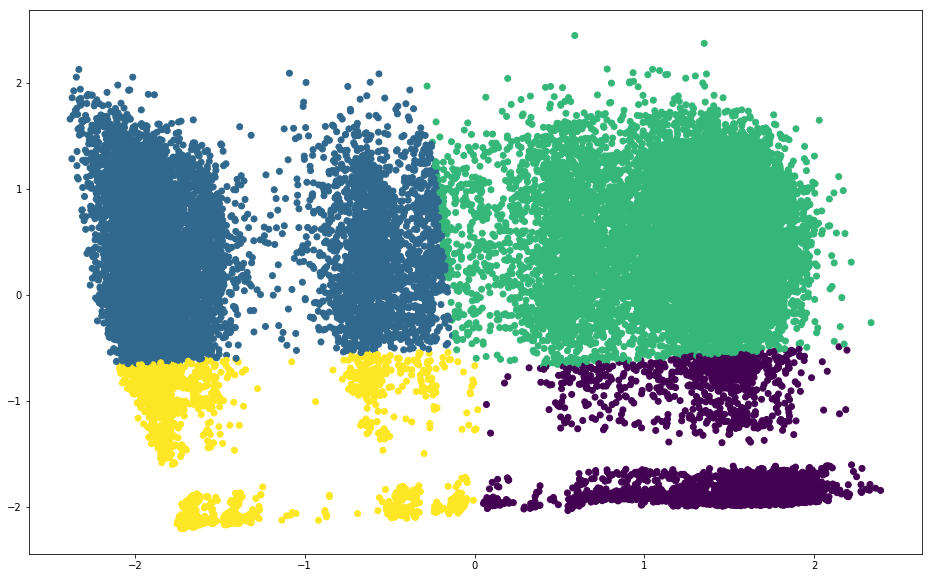

In [126]:
plt.pyplot.scatter(df_pca[:,0], df_pca[:,1], c=cluster_labels_km)

In [127]:
df['pca+kmeans'] = cluster_labels_km
X_train_km = df.loc[df.is_train]
X_test_km = df.loc[df.is_train == False]

In [128]:
lgb_train_km = lgb.Dataset(X_train_km.drop(['target', 'is_train'], axis=1), label=y_train, free_raw_data=False)

In [129]:
results_lgb_km = lgb.cv(params_lgb, lgb_train_km, 10000, folds=skf.split(X_train_km, y_train), early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.675146 + 0.0109169
[2]	cv_agg's auc: 0.698474 + 0.00928694
[3]	cv_agg's auc: 0.7027 + 0.00891798
[4]	cv_agg's auc: 0.70815 + 0.0078919
[5]	cv_agg's auc: 0.71055 + 0.00834864
[6]	cv_agg's auc: 0.711085 + 0.00849258
[7]	cv_agg's auc: 0.711915 + 0.0077444
[8]	cv_agg's auc: 0.712778 + 0.00832281
[9]	cv_agg's auc: 0.7128 + 0.00826943
[10]	cv_agg's auc: 0.713761 + 0.00824083
[11]	cv_agg's auc: 0.714922 + 0.0086138
[12]	cv_agg's auc: 0.715216 + 0.00853346
[13]	cv_agg's auc: 0.715346 + 0.00848047
[14]	cv_agg's auc: 0.715449 + 0.00844711
[15]	cv_agg's auc: 0.715919 + 0.00813974
[16]	cv_agg's auc: 0.716257 + 0.00842246
[17]	cv_agg's auc: 0.716665 + 0.00841067
[18]	cv_agg's auc: 0.716882 + 0.00831992
[19]	cv_agg's auc: 0.717027 + 0.0081589
[20]	cv_agg's auc: 0.717867 + 0.00827425
[21]	cv_agg's auc: 0.718649 + 0.00840598
[22]	cv_agg's auc: 0.718933 + 0.00862669
[23]	cv_agg's auc: 0.719461 + 0.00853872
[24]	cv_agg's auc: 0.719483 + 0.00845833
[25]	cv_agg's auc: 0.720128 + 0.0085

[201]	cv_agg's auc: 0.745044 + 0.00964123
[202]	cv_agg's auc: 0.745035 + 0.00965441
[203]	cv_agg's auc: 0.745139 + 0.0096352
[204]	cv_agg's auc: 0.745268 + 0.00960725
[205]	cv_agg's auc: 0.745284 + 0.00963708
[206]	cv_agg's auc: 0.745401 + 0.00953508
[207]	cv_agg's auc: 0.745329 + 0.00949653
[208]	cv_agg's auc: 0.745265 + 0.00954419
[209]	cv_agg's auc: 0.745352 + 0.00953363
[210]	cv_agg's auc: 0.745318 + 0.00958019
[211]	cv_agg's auc: 0.745289 + 0.00960785
[212]	cv_agg's auc: 0.745342 + 0.00966494
[213]	cv_agg's auc: 0.745386 + 0.00968053
[214]	cv_agg's auc: 0.745397 + 0.00970433
[215]	cv_agg's auc: 0.745438 + 0.00975368
[216]	cv_agg's auc: 0.745478 + 0.0097485
[217]	cv_agg's auc: 0.745554 + 0.00965124
[218]	cv_agg's auc: 0.745593 + 0.00958663
[219]	cv_agg's auc: 0.745586 + 0.00953917
[220]	cv_agg's auc: 0.745533 + 0.00957383
[221]	cv_agg's auc: 0.745449 + 0.00959161
[222]	cv_agg's auc: 0.745396 + 0.00959724
[223]	cv_agg's auc: 0.745492 + 0.00960002
[224]	cv_agg's auc: 0.745541 + 0.009

In [130]:
res_lgb_km = check_train_score(params_lgb, lgb_train_km, X_train_km.drop(['target', 'is_train'], axis=1), y_train, skf, len(results_lgb_km['auc-mean']))
print(f"Train score: {res_lgb_km[0]}, CV score: {res_lgb_km[1]}")

Train score: 0.8458932698801009, CV score: 0.7455934724705316


### umap+dbscan

In [142]:
X_train_with_target = X_train.copy() 
X_train_with_target['target'] = y_train
df = pd.concat([X_train_with_target, X_test], axis=0)
# add column for filtering train/test
df['is_train'] = True
df.loc[df['target'].isnull(), 'is_train'] = False

In [ ]:
df_ump=ump.fit_transform(df[df.columns[:-2]])

In [152]:
db = DBSCAN(
    eps=1,
    min_samples=25,
    n_jobs=3,
)


cluster_labels = db.fit_predict(df_ump)

# check statistics
print('Clusters found: {}'.format(np.unique(cluster_labels).shape[0]))
pd.Series(cluster_labels).value_counts()

Clusters found: 8


0    14721
1     9525
3     3437
5     2032
2     1463
7     1396
6     1015
4      954
dtype: int64

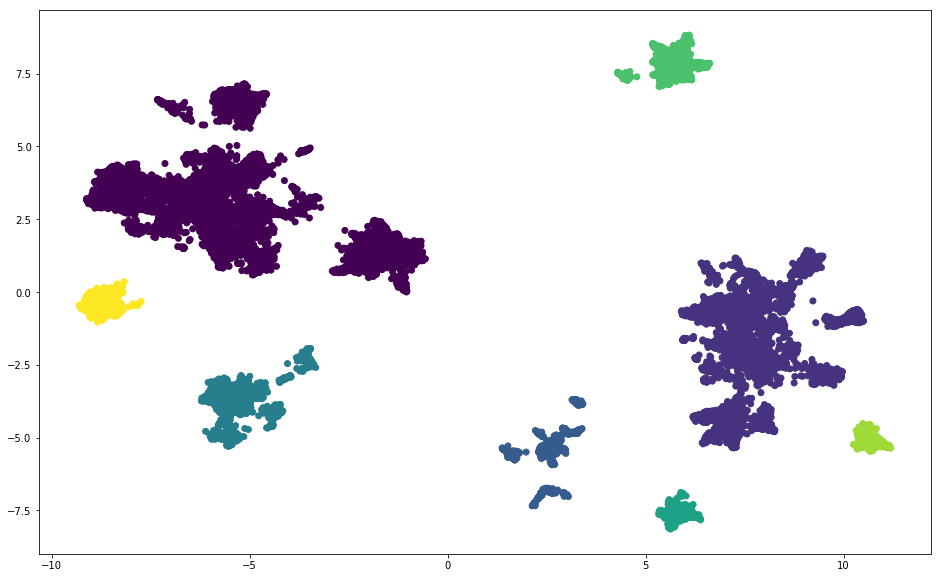

In [153]:
plt.pyplot.scatter(df_ump[:,0], df_ump[:,1], c=cluster_labels)

In [160]:
binary_columns = X_train.columns[np.where(X_train.nunique() == 2)[0]]

In [154]:
df['dbscan+umap'] = cluster_labels
X_train_dbscan = df.loc[df.is_train]
X_test_dbscan = df.loc[df.is_train == False]

In [189]:
lgb_train_dbscan = lgb.Dataset(X_train_dbscan.drop(['target', 'is_train'], axis=1), label=y_train, free_raw_data=False)

In [172]:
results_lgb_dbscan = lgb.cv(params_lgb, lgb_train_dbscan, 10000, folds=skf.split(X_train_dbscan, y_train), early_stopping_rounds=20, verbose_eval=1)

[1]	cv_agg's auc: 0.674502 + 0.010253
[2]	cv_agg's auc: 0.698161 + 0.00903581
[3]	cv_agg's auc: 0.702527 + 0.00891978
[4]	cv_agg's auc: 0.707983 + 0.00785718
[5]	cv_agg's auc: 0.710415 + 0.00828826
[6]	cv_agg's auc: 0.710939 + 0.00845454
[7]	cv_agg's auc: 0.711758 + 0.00769011
[8]	cv_agg's auc: 0.712674 + 0.0083181
[9]	cv_agg's auc: 0.712705 + 0.00826483
[10]	cv_agg's auc: 0.713654 + 0.00825485
[11]	cv_agg's auc: 0.714817 + 0.00861775
[12]	cv_agg's auc: 0.715104 + 0.00852925
[13]	cv_agg's auc: 0.71535 + 0.00848066
[14]	cv_agg's auc: 0.715444 + 0.00844752
[15]	cv_agg's auc: 0.715911 + 0.00813935
[16]	cv_agg's auc: 0.716272 + 0.008426
[17]	cv_agg's auc: 0.716659 + 0.0084093
[18]	cv_agg's auc: 0.716876 + 0.00832084
[19]	cv_agg's auc: 0.717029 + 0.00815873
[20]	cv_agg's auc: 0.717873 + 0.00827606
[21]	cv_agg's auc: 0.718581 + 0.0083872
[22]	cv_agg's auc: 0.718865 + 0.00860873
[23]	cv_agg's auc: 0.719433 + 0.00852584
[24]	cv_agg's auc: 0.719464 + 0.00844933
[25]	cv_agg's auc: 0.720111 + 0.0

[200]	cv_agg's auc: 0.745156 + 0.00956545
[201]	cv_agg's auc: 0.745155 + 0.00965267
[202]	cv_agg's auc: 0.745175 + 0.0096422
[203]	cv_agg's auc: 0.745273 + 0.00967297
[204]	cv_agg's auc: 0.745264 + 0.00964543
[205]	cv_agg's auc: 0.745324 + 0.0097086
[206]	cv_agg's auc: 0.745371 + 0.009745
[207]	cv_agg's auc: 0.74534 + 0.00970009
[208]	cv_agg's auc: 0.745329 + 0.00977806
[209]	cv_agg's auc: 0.745402 + 0.00979256
[210]	cv_agg's auc: 0.745468 + 0.00983008
[211]	cv_agg's auc: 0.745435 + 0.00988601
[212]	cv_agg's auc: 0.745497 + 0.00986398
[213]	cv_agg's auc: 0.745482 + 0.00988875
[214]	cv_agg's auc: 0.745529 + 0.0099289
[215]	cv_agg's auc: 0.745563 + 0.00997942
[216]	cv_agg's auc: 0.745574 + 0.00994246
[217]	cv_agg's auc: 0.745627 + 0.00990923
[218]	cv_agg's auc: 0.745639 + 0.00985934
[219]	cv_agg's auc: 0.745639 + 0.009868
[220]	cv_agg's auc: 0.745676 + 0.00980864
[221]	cv_agg's auc: 0.745622 + 0.00979103
[222]	cv_agg's auc: 0.745638 + 0.00978453
[223]	cv_agg's auc: 0.74562 + 0.00980342
[

In [197]:
lgb_model_dbscan = lgb.train(params_lgb,lgb_train_dbscan, len(results_lgb_dbscan['auc-mean']))
lgb_predictions_dbscan = lgb_model_dbscan.predict(X_test_dbscan)
make_file(lgb_predictions_dbscan, 'hw7_submissions/dbscan.csv')

## <center> Feature selecting

### Ручками

In [179]:
X_train_dp = X_train.drop(['3', '157', '191', '308', '300','269'], axis=1)
X_test_dp= X_test.drop(['3'], axis=1)
lgb_train_dp = lgb.Dataset(X_train_dp, label=y_train, free_raw_data=False) 
results_lgb_dp = lgb.cv(params_lgb, lgb_train_dp, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=30, verbose_eval=1)

[1]	cv_agg's auc: 0.682936 + 0.0104792
[2]	cv_agg's auc: 0.698401 + 0.00897657
[3]	cv_agg's auc: 0.703733 + 0.00894134
[4]	cv_agg's auc: 0.706437 + 0.00842604
[5]	cv_agg's auc: 0.708506 + 0.00853389
[6]	cv_agg's auc: 0.709731 + 0.00856291
[7]	cv_agg's auc: 0.710521 + 0.00898893
[8]	cv_agg's auc: 0.710471 + 0.00908618
[9]	cv_agg's auc: 0.710855 + 0.00932421
[10]	cv_agg's auc: 0.711496 + 0.00946904
[11]	cv_agg's auc: 0.711572 + 0.00946811
[12]	cv_agg's auc: 0.712659 + 0.00955255
[13]	cv_agg's auc: 0.713594 + 0.00935678
[14]	cv_agg's auc: 0.714696 + 0.00903576
[15]	cv_agg's auc: 0.715315 + 0.00882922
[16]	cv_agg's auc: 0.716117 + 0.00877383
[17]	cv_agg's auc: 0.716423 + 0.00887141
[18]	cv_agg's auc: 0.71657 + 0.0084891
[19]	cv_agg's auc: 0.717235 + 0.0083854
[20]	cv_agg's auc: 0.717767 + 0.00857293
[21]	cv_agg's auc: 0.718576 + 0.00879761
[22]	cv_agg's auc: 0.718697 + 0.00860243
[23]	cv_agg's auc: 0.719074 + 0.00844921
[24]	cv_agg's auc: 0.719869 + 0.00857059
[25]	cv_agg's auc: 0.720365 +

[202]	cv_agg's auc: 0.744921 + 0.0106183
[203]	cv_agg's auc: 0.744904 + 0.010592
[204]	cv_agg's auc: 0.744942 + 0.0105857
[205]	cv_agg's auc: 0.744987 + 0.0106093
[206]	cv_agg's auc: 0.744995 + 0.010528
[207]	cv_agg's auc: 0.745047 + 0.0105524
[208]	cv_agg's auc: 0.745087 + 0.0105905
[209]	cv_agg's auc: 0.745077 + 0.0106192
[210]	cv_agg's auc: 0.745145 + 0.0105879
[211]	cv_agg's auc: 0.7451 + 0.0105399
[212]	cv_agg's auc: 0.745231 + 0.0105192
[213]	cv_agg's auc: 0.745203 + 0.010477
[214]	cv_agg's auc: 0.745187 + 0.0104612
[215]	cv_agg's auc: 0.7453 + 0.0104685
[216]	cv_agg's auc: 0.745362 + 0.0104717
[217]	cv_agg's auc: 0.745374 + 0.0104629
[218]	cv_agg's auc: 0.745436 + 0.0105216
[219]	cv_agg's auc: 0.745447 + 0.0105102
[220]	cv_agg's auc: 0.745455 + 0.0104804
[221]	cv_agg's auc: 0.745417 + 0.0105535
[222]	cv_agg's auc: 0.745456 + 0.0105722
[223]	cv_agg's auc: 0.745487 + 0.0105761
[224]	cv_agg's auc: 0.745548 + 0.0105789
[225]	cv_agg's auc: 0.745588 + 0.0105593
[226]	cv_agg's auc: 0.7

[404]	cv_agg's auc: 0.747403 + 0.0111549
[405]	cv_agg's auc: 0.747402 + 0.0111895
[406]	cv_agg's auc: 0.74738 + 0.0111746
[407]	cv_agg's auc: 0.747451 + 0.0112076
[408]	cv_agg's auc: 0.747397 + 0.0112257
[409]	cv_agg's auc: 0.747416 + 0.0112533
[410]	cv_agg's auc: 0.747358 + 0.0112796
[411]	cv_agg's auc: 0.747361 + 0.0113075
[412]	cv_agg's auc: 0.747291 + 0.011283
[413]	cv_agg's auc: 0.747283 + 0.0112785
[414]	cv_agg's auc: 0.74734 + 0.0113043
[415]	cv_agg's auc: 0.747333 + 0.0113611
[416]	cv_agg's auc: 0.747326 + 0.0113603
[417]	cv_agg's auc: 0.747351 + 0.0114359
[418]	cv_agg's auc: 0.747399 + 0.011516
[419]	cv_agg's auc: 0.747374 + 0.0114897
[420]	cv_agg's auc: 0.747351 + 0.0114896
[421]	cv_agg's auc: 0.747395 + 0.0114801
[422]	cv_agg's auc: 0.747374 + 0.0115106
[423]	cv_agg's auc: 0.747345 + 0.0115076
[424]	cv_agg's auc: 0.74734 + 0.011486
[425]	cv_agg's auc: 0.74731 + 0.0114765
[426]	cv_agg's auc: 0.747333 + 0.0114676
[427]	cv_agg's auc: 0.747289 + 0.0114691


In [180]:
res_lgb_dp = check_train_score(params_lgb, lgb_train_dp, X_train_dp, y_train, skf, len(results_lgb_dp['auc-mean']))
print(f"Train score: {res_lgb_dp[0]}, CV score: {res_lgb_dp[1]}")

Train score: 0.8993733829982989, CV score: 0.7474828510756623


In [181]:
lgb_model_dp = lgb.train(params_lgb, lgb_train_dp, len(results_lgb_dp['auc-mean']))
lgb_predictions_dp = lgb_model_dp.predict(X_test_dp)
make_file(lgb_predictions_dp, "hw7_submissions/lgb_predictions_dp.csv")

### Variance Treshold

In [81]:
vt = VarianceThreshold(0.009)
vt.fit(X_train)
X_train_vt = vt.transform(X_train)
lgb_train_vt = lgb.Dataset(X_train_vt, label=y_train, free_raw_data=False) 
results_lgb_vt = lgb.cv(params_lgb, lgb_train_vt, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=30, verbose_eval=1)

[1]	cv_agg's auc: 0.68814 + 0.00846716
[2]	cv_agg's auc: 0.699371 + 0.00796262
[3]	cv_agg's auc: 0.704647 + 0.00686921
[4]	cv_agg's auc: 0.706494 + 0.00626249
[5]	cv_agg's auc: 0.708438 + 0.00694599
[6]	cv_agg's auc: 0.709965 + 0.00699121
[7]	cv_agg's auc: 0.710384 + 0.00725362
[8]	cv_agg's auc: 0.711336 + 0.00706729
[9]	cv_agg's auc: 0.712163 + 0.00735054
[10]	cv_agg's auc: 0.713315 + 0.00736657
[11]	cv_agg's auc: 0.713949 + 0.00814068
[12]	cv_agg's auc: 0.714167 + 0.00794787
[13]	cv_agg's auc: 0.714847 + 0.00841472
[14]	cv_agg's auc: 0.714912 + 0.00835707
[15]	cv_agg's auc: 0.715225 + 0.00802443
[16]	cv_agg's auc: 0.715427 + 0.00809878
[17]	cv_agg's auc: 0.716246 + 0.00774602
[18]	cv_agg's auc: 0.71645 + 0.00767884
[19]	cv_agg's auc: 0.716716 + 0.00774667
[20]	cv_agg's auc: 0.717307 + 0.00749048
[21]	cv_agg's auc: 0.717845 + 0.0073027
[22]	cv_agg's auc: 0.718142 + 0.0072138
[23]	cv_agg's auc: 0.71845 + 0.00729887
[24]	cv_agg's auc: 0.718501 + 0.00717649
[25]	cv_agg's auc: 0.718781 + 

[202]	cv_agg's auc: 0.743848 + 0.00918878
[203]	cv_agg's auc: 0.743903 + 0.00929226
[204]	cv_agg's auc: 0.744028 + 0.0092886
[205]	cv_agg's auc: 0.744064 + 0.00930799
[206]	cv_agg's auc: 0.743999 + 0.0092725
[207]	cv_agg's auc: 0.743991 + 0.00923761
[208]	cv_agg's auc: 0.744067 + 0.00927937
[209]	cv_agg's auc: 0.744177 + 0.00932096
[210]	cv_agg's auc: 0.744226 + 0.00930602
[211]	cv_agg's auc: 0.744186 + 0.00922867
[212]	cv_agg's auc: 0.744285 + 0.00918145
[213]	cv_agg's auc: 0.744325 + 0.00919656
[214]	cv_agg's auc: 0.744264 + 0.00922903
[215]	cv_agg's auc: 0.744294 + 0.00920469
[216]	cv_agg's auc: 0.74422 + 0.00913952
[217]	cv_agg's auc: 0.744231 + 0.00911496
[218]	cv_agg's auc: 0.744266 + 0.00904115
[219]	cv_agg's auc: 0.7444 + 0.0091209
[220]	cv_agg's auc: 0.744454 + 0.00909672
[221]	cv_agg's auc: 0.744465 + 0.00910494
[222]	cv_agg's auc: 0.744564 + 0.00911787
[223]	cv_agg's auc: 0.744585 + 0.00911051
[224]	cv_agg's auc: 0.744589 + 0.00913215
[225]	cv_agg's auc: 0.744605 + 0.0091020

In [82]:
res_lgb_vt = check_train_score_nd_array(params_lgb, lgb_train_vt, X_train_vt, y_train, skf, len(results_lgb_vt['auc-mean']))
print(f"Train score: {res_lgb_vt[0]}, CV score: {res_lgb_vt[1]}")

Train score: 0.8853119934027369, CV score: 0.7464407555113712


In [77]:
print(f'Base shape: {X_train.shape}, new shape: {X_train_vt.shape}')

Base shape: (30377, 322), new shape: (30377, 195)


In [100]:
lgb_model_vt = lgb.train(params_lgb, lgb_train_vt, len(results_lgb_vt['auc-mean']))
lgb_predictions_vt = lgb_model_vt.predict(vt.transform(X_test))
make_file(lgb_predictions_vt, "hw7_submissions/lgb_predictions_vt.csv")

### select k best

In [236]:
#0.76338379
kb = SelectKBest(f_classif, k=318).fit(X_train, y_train)
X_train_kb = kb.transform(X_train)
X_test_kb = kb.transform(X_test)
lgb_train_kb = lgb.Dataset(X_train_kb, label=y_train, free_raw_data=False) 
results_lgb_kb = lgb.cv(params_lgb, lgb_train_kb, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=30, verbose_eval=1)

[1]	cv_agg's auc: 0.680315 + 0.0128203
[2]	cv_agg's auc: 0.696142 + 0.00996407
[3]	cv_agg's auc: 0.699591 + 0.0104334
[4]	cv_agg's auc: 0.705501 + 0.00889166
[5]	cv_agg's auc: 0.706732 + 0.00900071
[6]	cv_agg's auc: 0.708186 + 0.00811037
[7]	cv_agg's auc: 0.708297 + 0.00780926
[8]	cv_agg's auc: 0.708803 + 0.00751531
[9]	cv_agg's auc: 0.709877 + 0.00781669
[10]	cv_agg's auc: 0.710531 + 0.00752428
[11]	cv_agg's auc: 0.712002 + 0.00818066
[12]	cv_agg's auc: 0.712775 + 0.00803902
[13]	cv_agg's auc: 0.71325 + 0.00816779
[14]	cv_agg's auc: 0.714112 + 0.00777651
[15]	cv_agg's auc: 0.714653 + 0.00791984
[16]	cv_agg's auc: 0.715256 + 0.00776837
[17]	cv_agg's auc: 0.715765 + 0.00784925
[18]	cv_agg's auc: 0.715788 + 0.00802411
[19]	cv_agg's auc: 0.715924 + 0.00782017
[20]	cv_agg's auc: 0.716577 + 0.00824368
[21]	cv_agg's auc: 0.717234 + 0.00831295
[22]	cv_agg's auc: 0.717795 + 0.00839519
[23]	cv_agg's auc: 0.718306 + 0.008154
[24]	cv_agg's auc: 0.718633 + 0.00807422
[25]	cv_agg's auc: 0.719342 + 

[202]	cv_agg's auc: 0.745067 + 0.0106619
[203]	cv_agg's auc: 0.745114 + 0.0106128
[204]	cv_agg's auc: 0.745131 + 0.0106334
[205]	cv_agg's auc: 0.745222 + 0.0106111
[206]	cv_agg's auc: 0.745123 + 0.0106401
[207]	cv_agg's auc: 0.745132 + 0.0106294
[208]	cv_agg's auc: 0.745174 + 0.010643
[209]	cv_agg's auc: 0.745215 + 0.0106895
[210]	cv_agg's auc: 0.745211 + 0.0107137
[211]	cv_agg's auc: 0.745223 + 0.0107394
[212]	cv_agg's auc: 0.745292 + 0.0107049
[213]	cv_agg's auc: 0.745311 + 0.0106977
[214]	cv_agg's auc: 0.745221 + 0.0107185
[215]	cv_agg's auc: 0.745152 + 0.0107775
[216]	cv_agg's auc: 0.745157 + 0.0107833
[217]	cv_agg's auc: 0.745181 + 0.0108042
[218]	cv_agg's auc: 0.745237 + 0.0107547
[219]	cv_agg's auc: 0.745357 + 0.0107746
[220]	cv_agg's auc: 0.745323 + 0.0108022
[221]	cv_agg's auc: 0.745359 + 0.0109039
[222]	cv_agg's auc: 0.745372 + 0.0109431
[223]	cv_agg's auc: 0.745392 + 0.0109011
[224]	cv_agg's auc: 0.745453 + 0.0109911
[225]	cv_agg's auc: 0.745458 + 0.0108958
[226]	cv_agg's au

[403]	cv_agg's auc: 0.747084 + 0.0110788
[404]	cv_agg's auc: 0.747081 + 0.011163


In [237]:
res_lgb_kb = check_train_score_nd_array(params_lgb, lgb_train_kb, X_train_kb, y_train, skf, len(results_lgb_kb['auc-mean']))
print(f"Train score: {res_lgb_kb[0]}, CV score: {res_lgb_kb[1]}")

Train score: 0.8940363452078698, CV score: 0.7475265639957878


In [219]:
lgb_model_kb = lgb.train(params_lgb, lgb_train_kb, len(results_lgb_kb['auc-mean']))
lgb_predictions_kb = lgb_model_kb.predict(X_test_kb)
make_file(lgb_predictions_kb, "hw7_submissions/lgb_predictions_kb.csv")

### Select from model

In [208]:
sfm = SelectFromModel(best_rf).fit(X_train, y_train)

In [38]:
X_train_sfm = sfm.transform(X_train)
X_test_sfm = sfm.transform(X_test)
lgb_train_sfm = lgb.Dataset(X_train_sfm, label=y_train, free_raw_data=False) 
results_lgb_sfm = lgb.cv(params_lgb, lgb_train_sfm, 10000, folds=skf.split(X_train, y_train), early_stopping_rounds=30, verbose_eval=1)

[1]	cv_agg's auc: 0.678811 + 0.0118017
[2]	cv_agg's auc: 0.690827 + 0.00844531
[3]	cv_agg's auc: 0.702962 + 0.0069634
[4]	cv_agg's auc: 0.704933 + 0.00696418
[5]	cv_agg's auc: 0.705662 + 0.00799755
[6]	cv_agg's auc: 0.706758 + 0.00822979
[7]	cv_agg's auc: 0.708589 + 0.00711042
[8]	cv_agg's auc: 0.708948 + 0.00783257
[9]	cv_agg's auc: 0.709806 + 0.0081245
[10]	cv_agg's auc: 0.710605 + 0.00801802
[11]	cv_agg's auc: 0.710519 + 0.00802814
[12]	cv_agg's auc: 0.711126 + 0.00789872
[13]	cv_agg's auc: 0.711789 + 0.00836135
[14]	cv_agg's auc: 0.711786 + 0.00849164
[15]	cv_agg's auc: 0.712157 + 0.0085202
[16]	cv_agg's auc: 0.71251 + 0.008508
[17]	cv_agg's auc: 0.712727 + 0.00866099
[18]	cv_agg's auc: 0.713015 + 0.00885971
[19]	cv_agg's auc: 0.713001 + 0.00883945
[20]	cv_agg's auc: 0.713435 + 0.00884905
[21]	cv_agg's auc: 0.713509 + 0.00859757
[22]	cv_agg's auc: 0.71345 + 0.00862348
[23]	cv_agg's auc: 0.713723 + 0.00855335
[24]	cv_agg's auc: 0.714156 + 0.0086047
[25]	cv_agg's auc: 0.714443 + 0.00

[201]	cv_agg's auc: 0.736461 + 0.0104513
[202]	cv_agg's auc: 0.736433 + 0.0104872
[203]	cv_agg's auc: 0.736499 + 0.0105651
[204]	cv_agg's auc: 0.736452 + 0.010608
[205]	cv_agg's auc: 0.736474 + 0.0105753
[206]	cv_agg's auc: 0.736576 + 0.0106513
[207]	cv_agg's auc: 0.736661 + 0.0105622
[208]	cv_agg's auc: 0.736694 + 0.010582
[209]	cv_agg's auc: 0.736753 + 0.0106763
[210]	cv_agg's auc: 0.736706 + 0.0106125
[211]	cv_agg's auc: 0.736677 + 0.0105373
[212]	cv_agg's auc: 0.736696 + 0.0105263
[213]	cv_agg's auc: 0.736794 + 0.0105476
[214]	cv_agg's auc: 0.736718 + 0.0105733
[215]	cv_agg's auc: 0.736716 + 0.0105766
[216]	cv_agg's auc: 0.736674 + 0.0105894
[217]	cv_agg's auc: 0.736706 + 0.0105057
[218]	cv_agg's auc: 0.736694 + 0.0104264
[219]	cv_agg's auc: 0.736652 + 0.0105067
[220]	cv_agg's auc: 0.736654 + 0.0105398
[221]	cv_agg's auc: 0.736816 + 0.0105172
[222]	cv_agg's auc: 0.736803 + 0.0105605
[223]	cv_agg's auc: 0.736896 + 0.0105229
[224]	cv_agg's auc: 0.736949 + 0.0105914
[225]	cv_agg's auc

In [39]:
res_lgb_sfm = check_train_score_nd_array(params_lgb, lgb_train_sfm, X_train_sfm, y_train, skf, len(results_lgb_sfm['auc-mean']))
print(f"Train score: {res_lgb_sfm[0]}, CV score: {res_lgb_sfm[1]}")

Train score: 0.8884049024468117, CV score: 0.7395199319246875


## Помогите Даше найти категориальные фичи

In [88]:
# by Stas Semenov

import time
import numpy as np

class SemenovEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        
        
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = SemenovEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

### бинарные колонки

In [89]:

binary_columns = X_train.columns[np.where(X_train.nunique() == 2)[0]]

In [90]:
def union(row, columns):
    string = ''
    for column in columns:
        column = str(column)
        string += str(int(row[column]))
    if string.count('1') == 1:
        return string[string.index('1'):].count('0')
    number = int(string, 2)
    return np.log2(number) if number else number-1

In [124]:
train = pd.read_csv('../data/train_5.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/test_5.csv', sep='\t', index_col=0)

In [125]:
X_with_features_train = X_train.copy()
X_with_features_test = X_test.copy()
train_tmp = train.copy()
test_tmp = test.copy()

test_tmp['union_fourth'] = test_tmp.apply(partial(union, columns=[str(x) for x in range(1,4)if str(x) in binary_columns]), axis=1)
train_tmp['union_fourth'] = train_tmp.apply(partial(union, columns=[str(x) for x in range(1,4) if str(x) in binary_columns]), axis=1)
X_with_features_train['union_fourth'] = train_tmp['union_fourth'].apply(lambda x: str(x))
X_with_features_test['union_fourth'] = test_tmp['union_fourth'].apply(lambda x: str(x))

In [126]:
X_with_features_train.drop([str(x) for x in range(1,4)if str(x) in binary_columns], axis=1, inplace=True)
X_with_features_test.drop([str(x) for x in range(1,4)if str(x) in binary_columns], axis=1, inplace=True)

In [127]:
X_with_features_train['target'] = y_train

In [128]:
%%time
#lb 0.76435039

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X_with_features_train.drop('target', axis=1), y_train): 
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        X_with_features_train.iloc[train_split], 
        y_train.iloc[train_split], 
        X_with_features_train.iloc[val_split], 

        ['union_fourth']
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = SemenovEncoding()
    se.fit(X_with_features_train.iloc[train_split], y_train.iloc[train_split],
           ['union_fourth'])
    main_train_dfs.append(
        se.transform(X_with_features_train.iloc[val_split], inplace=False)
    )
    
se.fit(X_with_features_train, y_train, features=['union_fourth'])
main_test = se.transform(X_with_features_test, inplace=False)

CPU times: user 5.43 s, sys: 2.08 s, total: 7.51 s
Wall time: 3.79 s


In [129]:
new_train_dfs = [pd.concat(i, axis=0) for i in new_train_dfs]

In [130]:
main_train = pd.concat(main_train_dfs, axis=0, ignore_index=True)

In [131]:
lgb_train_cat = lgb.Dataset(main_train.drop('target', axis=1), label=y_train, free_raw_data=False)

In [132]:
params_lgb_first = params_lgb

In [133]:
scores = []
results = []
for train, val in zip(new_train_dfs, new_val_dfs):
    tr= len(train)
    vl=len(val)
    all_set = pd.concat([train, val], axis=0, ignore_index=True)
    a = np.array(all_set.iloc[:tr, :].index)
    b =np.array(all_set.iloc[-vl:, :].index)
    df = lgb.Dataset(all_set.drop("target", axis=1), label=all_set['target'], free_raw_data=False)
    res = lgb.cv(params_lgb_first,df, 10000,folds=[(a,b)],early_stopping_rounds=30)
    lgb_train_first = lgb.train(params_lgb_first,
                                lgb.Dataset(train.drop('target', axis=1), label=train['target'], free_raw_data=False),
                               len(res['auc-mean']))
    scores.append([roc_auc_score(train['target'], lgb_train_first.predict(train.drop('target', axis=1))),
                   roc_auc_score(val['target'], lgb_train_first.predict(val.drop('target', axis=1)))])
    results.append(len(res['auc-mean']))

In [134]:
print(f"cv score: {np.array(scores)[:,1].mean()}")

cv score: 0.7465705387932003


In [135]:
print(f"train score: {np.array(scores)[:,0].mean()}")

train score: 0.8557232929644225


In [65]:
results

[273, 194, 328, 293, 335, 316, 224, 134, 197, 240]

In [66]:
scores

[[0.8648477384972785, 0.7413146783600634],
 [0.8362402733673266, 0.7362340889347336],
 [0.8822580092562193, 0.7469361811075479],
 [0.8695324959596814, 0.7614513833288854],
 [0.8821062142523628, 0.7610176656432163],
 [0.8797908444825052, 0.7403202361352139],
 [0.847436186076052, 0.7264554502439965],
 [0.8064492292351837, 0.7505124668120263],
 [0.8365534733423802, 0.7511651018258948],
 [0.852018465175236, 0.7502981355404262]]

In [67]:
lgb_model_categorical = lgb.train(params_lgb_first, lgb_train_cat, 293)
lgb_predictions_categorical = lgb_model_categorical.predict(main_test)
make_file(lgb_predictions_categorical, "hw7_submissions/lgb_predictions_categorical.csv")

NameError: name 'make_file' is not defined

### остальные

In [28]:
numeric_columns = X_train.columns[np.where(X_train.nunique() > 2)[0]]

In [29]:
s = X_train.columns[np.where(X_train.nunique()== X_test.nunique())[0]]
same_columns = [x for x in s if x in numeric_columns]

In [30]:
X_with_features_train = X_train.copy()
X_with_features_test = X_test.copy()
X_with_features_train['target'] = y_train

In [31]:
try_cat = ['117', '124', '341']

In [32]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(X_with_features_train.drop('target', axis=1), y_train): 
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        X_with_features_train.iloc[train_split], 
        y_train.iloc[train_split], 
        X_with_features_train.iloc[val_split], 
       # ['union_first', 'union_second', 'union_third']
        try_cat
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = SemenovEncoding()
    se.fit(X_with_features_train.iloc[train_split], y_train.iloc[train_split],
          try_cat)
    main_train_dfs.append(
        se.transform(X_with_features_train.iloc[val_split], inplace=False)
    )
    
se.fit(X_with_features_train, y_train, features=try_cat)
main_test = se.transform(X_with_features_test, inplace=False)

CPU times: user 16.3 s, sys: 228 ms, total: 16.5 s
Wall time: 8.28 s


In [33]:
new_train_dfs = [pd.concat(i, axis=0) for i in new_train_dfs]

In [34]:
main_train = pd.concat(main_train_dfs, axis=0, ignore_index=True)

In [35]:
lgb_train_cat = lgb.Dataset(main_train.drop('target', axis=1), label=y_train, free_raw_data=False)

In [36]:
params_lgb_first = params_lgb

In [37]:
scores = []
results = []
for train, val in zip(new_train_dfs, new_val_dfs):
    tr= len(train)
    vl=len(val)
    all_set = pd.concat([train, val], axis=0, ignore_index=True)
    a = np.array(all_set.iloc[:tr, :].index)
    b =np.array(all_set.iloc[-vl:, :].index)
    df = lgb.Dataset(all_set.drop("target", axis=1), label=all_set['target'], free_raw_data=False)
    res = lgb.cv(params_lgb_first,df, 10000,folds=[(a,b)],early_stopping_rounds=30)
    lgb_train_first = lgb.train(params_lgb_first,
                                lgb.Dataset(train.drop('target', axis=1), label=train['target'], free_raw_data=False),
                               len(res['auc-mean']))
    scores.append([roc_auc_score(train['target'], lgb_train_first.predict(train.drop('target', axis=1))),
                   roc_auc_score(val['target'], lgb_train_first.predict(val.drop('target', axis=1)))])
    results.append(len(res['auc-mean']))

In [38]:
print(f"cv score: {np.array(scores)[:,1].mean()}")

cv score: 0.7449413642258045


## <center> XGBFir

In [222]:
#lb 0.76400395
xgbfir.saveXgbFI(
    xgb_model, 
    feature_names=X_train.columns, 
    OutputXlsxFile=( "xgbfir_importance.xlsx"))

In [192]:
X_train_xgbfir = X_train.copy()
X_test_xgbfir = X_test.copy()

X_train_xgbfir['338|339'] = X_train['338'] * X_train['339']
X_test_xgbfir['338|339'] = X_test['338'] * X_test['339']


X_train_xgbfir['144|338|339'] =( X_train['338'] * X_train['339'] *X_train['144'])**(1/3)
X_test_xgbfir['144|338|339'] = (X_test['338'] * X_test['339'] * X_train['144'])**(1/3)
X_train_xgbfir['4|338|339'] =( X_train['338'] * X_train['339'] *X_train['4'])**(1/3)
X_test_xgbfir['4|338|339'] = (X_test['338'] * X_test['339'] * X_train['4'])**(1/3)

In [193]:
xgb_train_xgbfir = xgb.DMatrix(X_train_xgbfir, y_train, feature_names=X_train_xgbfir.columns)
xgb_test_xgbfir = xgb.DMatrix(X_test_xgbfir, feature_names=X_train_xgbfir.columns)

In [194]:
#lb 0.76435039
params_xgbfir = {'colsample_bytree': 0.7,
 'eta': 0.01,
 'eval_metric': 'auc',
 'grow_policy': 'lossguide',
 'max_depth': 8,
 'max_leaves': 65,
 'nthread': 4,
 'objective': 'binary:logistic',
 'random_seed': 42,
 'silent': 1,
 'subsample': 0.9,
 'tree_method': 'hist'}

In [195]:
results_xgb_xgbfir = xgb.cv(params_xgbfir, xgb_train_xgbfir, num_boost_round=10000, folds=skf, early_stopping_rounds=50, verbose_eval=1)

[0]	train-auc:0.715986+0.00316393	test-auc:0.68185+0.00693937
[1]	train-auc:0.732799+0.000791581	test-auc:0.697473+0.00587355
[2]	train-auc:0.741565+0.00278379	test-auc:0.703382+0.00509977
[3]	train-auc:0.746594+0.00355752	test-auc:0.706602+0.00520221
[4]	train-auc:0.748625+0.00405814	test-auc:0.707366+0.00592139
[5]	train-auc:0.75145+0.00360449	test-auc:0.708854+0.00529146
[6]	train-auc:0.754379+0.00427567	test-auc:0.709796+0.00513429
[7]	train-auc:0.75545+0.00535106	test-auc:0.710442+0.00548641
[8]	train-auc:0.756712+0.00448098	test-auc:0.71162+0.00557298
[9]	train-auc:0.757496+0.00446248	test-auc:0.711964+0.00522601
[10]	train-auc:0.758112+0.00422838	test-auc:0.712579+0.00484977
[11]	train-auc:0.75858+0.00463759	test-auc:0.713245+0.00460114
[12]	train-auc:0.759201+0.00508079	test-auc:0.713485+0.00471521
[13]	train-auc:0.759995+0.00553543	test-auc:0.714242+0.00413046
[14]	train-auc:0.760812+0.00551017	test-auc:0.714613+0.00380789
[15]	train-auc:0.761928+0.00538252	test-auc:0.715235+0

[129]	train-auc:0.799781+0.00393462	test-auc:0.725223+0.0039459
[130]	train-auc:0.800065+0.00395409	test-auc:0.725385+0.00392767
[131]	train-auc:0.800462+0.00382097	test-auc:0.725336+0.00389641
[132]	train-auc:0.800953+0.00402931	test-auc:0.725443+0.00392039
[133]	train-auc:0.80124+0.00412082	test-auc:0.725492+0.00392723
[134]	train-auc:0.801486+0.00406644	test-auc:0.72554+0.00395495
[135]	train-auc:0.801762+0.00404144	test-auc:0.725688+0.00404198
[136]	train-auc:0.802118+0.00394908	test-auc:0.725702+0.00410664
[137]	train-auc:0.802397+0.00394369	test-auc:0.725753+0.00405651
[138]	train-auc:0.802661+0.00396699	test-auc:0.725834+0.00406746
[139]	train-auc:0.803073+0.00383789	test-auc:0.72593+0.00413285
[140]	train-auc:0.803442+0.00390045	test-auc:0.72605+0.00408028
[141]	train-auc:0.803751+0.00390829	test-auc:0.726104+0.00410766
[142]	train-auc:0.804104+0.00379838	test-auc:0.726198+0.00407421
[143]	train-auc:0.804565+0.00368033	test-auc:0.726316+0.00410984
[144]	train-auc:0.804777+0.003

[257]	train-auc:0.844768+0.00200778	test-auc:0.734591+0.00487779
[258]	train-auc:0.845022+0.00200013	test-auc:0.734629+0.00489031
[259]	train-auc:0.845442+0.00196843	test-auc:0.734748+0.00489703
[260]	train-auc:0.845784+0.00194064	test-auc:0.734836+0.00489602
[261]	train-auc:0.846117+0.00191586	test-auc:0.734941+0.00490082
[262]	train-auc:0.846468+0.00183044	test-auc:0.735031+0.00489762
[263]	train-auc:0.84678+0.00182339	test-auc:0.73506+0.00490773
[264]	train-auc:0.847094+0.0018363	test-auc:0.735079+0.00490031
[265]	train-auc:0.847419+0.00183899	test-auc:0.735115+0.00489168
[266]	train-auc:0.847786+0.00184512	test-auc:0.73513+0.00489467
[267]	train-auc:0.848025+0.00186905	test-auc:0.735184+0.00488928
[268]	train-auc:0.848357+0.00184431	test-auc:0.735273+0.00482899
[269]	train-auc:0.848694+0.00183452	test-auc:0.735339+0.00486101
[270]	train-auc:0.849055+0.00170321	test-auc:0.735361+0.00489817
[271]	train-auc:0.849336+0.00167233	test-auc:0.735393+0.00490347
[272]	train-auc:0.849625+0.00

[384]	train-auc:0.879318+0.00137082	test-auc:0.739274+0.00534071
[385]	train-auc:0.8795+0.00136692	test-auc:0.739311+0.00531995
[386]	train-auc:0.879744+0.00135286	test-auc:0.739336+0.00530968
[387]	train-auc:0.879916+0.00134585	test-auc:0.73935+0.00532071
[388]	train-auc:0.88015+0.00130502	test-auc:0.739381+0.00530071
[389]	train-auc:0.880443+0.00129456	test-auc:0.739355+0.00534316
[390]	train-auc:0.880664+0.001323	test-auc:0.739374+0.00534275
[391]	train-auc:0.880911+0.00133497	test-auc:0.739396+0.0053481
[392]	train-auc:0.881149+0.00137912	test-auc:0.739419+0.00532315
[393]	train-auc:0.881403+0.00132776	test-auc:0.739407+0.00529954
[394]	train-auc:0.881646+0.00135082	test-auc:0.739419+0.0052628
[395]	train-auc:0.881932+0.00134274	test-auc:0.739421+0.00523093
[396]	train-auc:0.88218+0.00134069	test-auc:0.739442+0.00524048
[397]	train-auc:0.882418+0.00132505	test-auc:0.739468+0.00526898
[398]	train-auc:0.882575+0.00132947	test-auc:0.739496+0.0052416
[399]	train-auc:0.882804+0.00142025

[511]	train-auc:0.904162+0.00141759	test-auc:0.740798+0.00539093
[512]	train-auc:0.904357+0.0013855	test-auc:0.740811+0.00540573
[513]	train-auc:0.904537+0.00145115	test-auc:0.740798+0.00540819
[514]	train-auc:0.90468+0.00151141	test-auc:0.740834+0.00540724
[515]	train-auc:0.904854+0.00153641	test-auc:0.740825+0.005411
[516]	train-auc:0.905028+0.00151429	test-auc:0.74086+0.00540837
[517]	train-auc:0.90524+0.00146428	test-auc:0.740862+0.00538668
[518]	train-auc:0.905401+0.00150585	test-auc:0.740861+0.00537606
[519]	train-auc:0.905614+0.00151562	test-auc:0.740908+0.00535563
[520]	train-auc:0.90573+0.00152518	test-auc:0.740923+0.0053386
[521]	train-auc:0.905876+0.00158773	test-auc:0.740946+0.00536347
[522]	train-auc:0.906075+0.00155434	test-auc:0.740951+0.00530021
[523]	train-auc:0.906239+0.00155003	test-auc:0.740932+0.00528786
[524]	train-auc:0.906375+0.00154588	test-auc:0.740935+0.0052877
[525]	train-auc:0.906511+0.00156718	test-auc:0.740941+0.0052848
[526]	train-auc:0.906675+0.00156824

[639]	train-auc:0.923366+0.00153665	test-auc:0.741441+0.00543847
[640]	train-auc:0.923471+0.00152902	test-auc:0.741451+0.00544765
[641]	train-auc:0.923574+0.00153828	test-auc:0.741471+0.0054468
[642]	train-auc:0.923733+0.00154348	test-auc:0.741473+0.00547305
[643]	train-auc:0.923854+0.00154163	test-auc:0.741498+0.00544507
[644]	train-auc:0.923973+0.00156168	test-auc:0.741513+0.00543242
[645]	train-auc:0.924118+0.00153407	test-auc:0.741497+0.0054444
[646]	train-auc:0.924238+0.00153067	test-auc:0.741475+0.00544946
[647]	train-auc:0.924358+0.00156398	test-auc:0.741481+0.00546487
[648]	train-auc:0.924507+0.00151618	test-auc:0.741482+0.0054734
[649]	train-auc:0.924639+0.00154433	test-auc:0.741487+0.00547027
[650]	train-auc:0.924768+0.00153254	test-auc:0.741482+0.00550651
[651]	train-auc:0.924931+0.00154756	test-auc:0.741505+0.00549636
[652]	train-auc:0.925055+0.00156837	test-auc:0.741498+0.00550991
[653]	train-auc:0.925212+0.00157343	test-auc:0.741521+0.00551674
[654]	train-auc:0.925338+0.0

[766]	train-auc:0.937979+0.00168455	test-auc:0.741916+0.00575433
[767]	train-auc:0.938079+0.0016664	test-auc:0.74194+0.00576728
[768]	train-auc:0.93817+0.00170823	test-auc:0.741943+0.00577786
[769]	train-auc:0.938303+0.0017155	test-auc:0.74193+0.00578476
[770]	train-auc:0.938392+0.00175436	test-auc:0.741931+0.00578932
[771]	train-auc:0.938483+0.00169274	test-auc:0.741925+0.00580871
[772]	train-auc:0.938601+0.00166787	test-auc:0.741933+0.00581191
[773]	train-auc:0.938715+0.00164719	test-auc:0.741944+0.00581883
[774]	train-auc:0.938829+0.00164341	test-auc:0.74196+0.00579034
[775]	train-auc:0.938934+0.00165442	test-auc:0.741942+0.005785
[776]	train-auc:0.93901+0.00165451	test-auc:0.741941+0.00577294
[777]	train-auc:0.939133+0.00164222	test-auc:0.741936+0.005794
[778]	train-auc:0.939247+0.00166625	test-auc:0.741932+0.00579565
[779]	train-auc:0.939339+0.00163878	test-auc:0.74196+0.00579406
[780]	train-auc:0.939445+0.00160843	test-auc:0.741966+0.00580537
[781]	train-auc:0.939551+0.00157886	t

[893]	train-auc:0.949932+0.00116813	test-auc:0.74241+0.00596396
[894]	train-auc:0.950007+0.00119581	test-auc:0.742413+0.00593931
[895]	train-auc:0.950096+0.00122415	test-auc:0.742413+0.00595538
[896]	train-auc:0.950153+0.00123702	test-auc:0.742419+0.0059591
[897]	train-auc:0.950257+0.00123888	test-auc:0.742427+0.00595881
[898]	train-auc:0.950367+0.00126496	test-auc:0.742448+0.0059503
[899]	train-auc:0.950493+0.00125536	test-auc:0.742466+0.00591125
[900]	train-auc:0.950581+0.00125125	test-auc:0.742462+0.00592333
[901]	train-auc:0.950659+0.00126393	test-auc:0.742459+0.00591872
[902]	train-auc:0.950756+0.00130514	test-auc:0.742459+0.00592094
[903]	train-auc:0.950838+0.00131747	test-auc:0.742441+0.00592943
[904]	train-auc:0.950905+0.00135201	test-auc:0.742431+0.00591439
[905]	train-auc:0.950969+0.00135292	test-auc:0.742408+0.00590439
[906]	train-auc:0.951022+0.00136384	test-auc:0.742406+0.00590485
[907]	train-auc:0.951116+0.00133524	test-auc:0.742412+0.00592396
[908]	train-auc:0.951207+0.0

In [196]:
results_xgb_xgbfir.iloc[-1, :]

test-auc-mean     0.742466
test-auc-std      0.005911
train-auc-mean    0.950493
train-auc-std     0.001255
Name: 899, dtype: float64

In [228]:
xgb_model_xgbfir = xgb.train(params_xgbfir, xgb_train_xgbfir, len(results_xgb_xgbfir))

In [229]:
xgbfir_predictions = xgb_model_xgbfir.predict(xgb_test_xgbfir)
make_file(xgbfir_predictions, 'hw7_submissions/xgbfir.csv')